# TUTORIAL: Class ESN_model

The class `ESN_model` defined in `src.models_datadriven` and it combines the classes `EchoStateNetwork`, from `ML_models.EchoStateNetwork`, and `Model` `from src.model`.



In [1]:
from src.models_datadriven import ESN_model


## Initialisation 
To create a any model from `models_datadriven` we need some data to learn. Let's use the Lorenz 63 again.

Loaded case


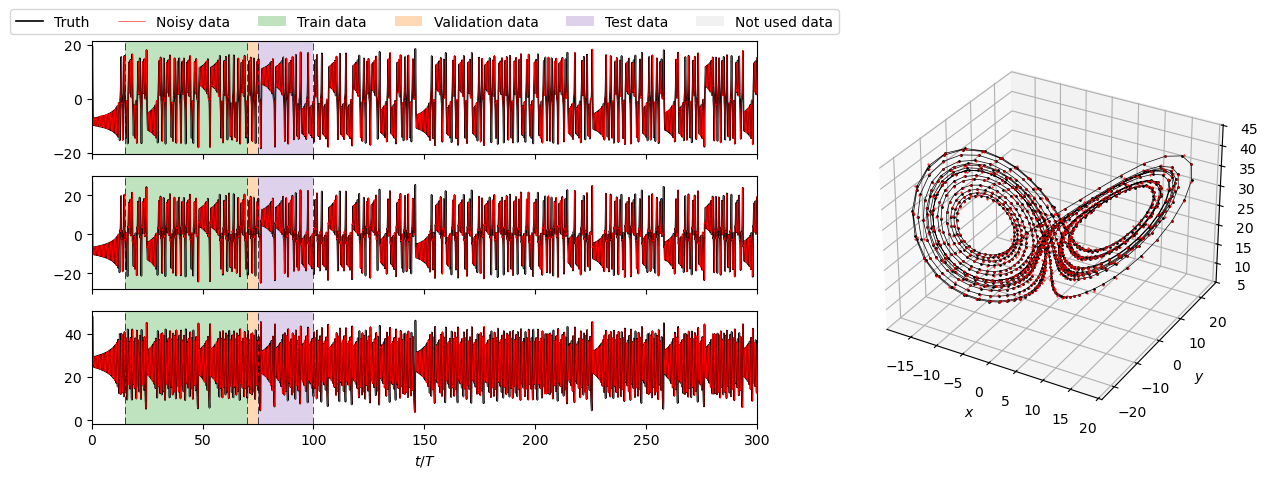

In [2]:
from src.plot_results import plot_train_dataset
from src.utils import create_Lorenz63_dataset

dataset = create_Lorenz63_dataset(noise_level=0.02, 
                                  num_lyap_times=300)


clean_data, noisy_data, t, N_lyap = [dataset[key] for key in ['clean_data', 'noisy_data', 
                                                              't', 'N_lyap']]

dt = t[1] - t[0]
t_lyap = N_lyap * dt


# Split the dataset 
N_transient = 15 * N_lyap
N_val = 5 * N_lyap
N_train = 60 * N_lyap - N_val 
N_test = 5 * N_val


# Visualize
split_times = [tt / N_lyap for tt in [N_transient, N_train, N_val, N_test]]
plot_train_dataset(clean_data, noisy_data, t/t_lyap, *split_times)

In [3]:
print(sum([N_transient, N_train, N_val, N_test]) * dt/t_lyap)

99.99999999999999



 ----------------- HYPERPARAMETER SEARCH ------------------
 5x5 grid and 15 points with Bayesian Optimization
		 rho	 sigma_in	 tikh	 MSE val 
1	 2.000e-01	 5.000e-01	 1.000e-12	 -1.2751
2	 2.000e-01	 1.581e+00	 1.000e-06	 -0.8214
3	 2.000e-01	 5.000e+00	 1.000e-06	 -1.2507
4	 2.000e-01	 1.581e+01	 1.000e-06	 -0.9205
5	 2.000e-01	 5.000e+01	 1.000e-06	 -0.0242
6	 3.500e-01	 5.000e-01	 1.000e-06	 -0.6552
7	 3.500e-01	 1.581e+00	 1.000e-06	 -0.8148
8	 3.500e-01	 5.000e+00	 1.000e-06	 -1.2917
9	 3.500e-01	 1.581e+01	 1.000e-12	 -1.3798
10	 3.500e-01	 5.000e+01	 1.000e-12	 -0.2249
11	 5.000e-01	 5.000e-01	 1.000e-06	 -0.5231
12	 5.000e-01	 1.581e+00	 1.000e-06	 -0.9570
13	 5.000e-01	 5.000e+00	 1.000e-12	 -1.2114
14	 5.000e-01	 1.581e+01	 1.000e-12	 -1.1933
15	 5.000e-01	 5.000e+01	 1.000e-09	 0.2166
16	 6.500e-01	 5.000e-01	 1.000e-06	 -0.6568
17	 6.500e-01	 1.581e+00	 1.000e-06	 -1.1896
18	 6.500e-01	 5.000e+00	 1.000e-06	 -1.1940
19	 6.500e-01	 1.581e+01	 1.000e-12	 -1.2318
20	 6.500e

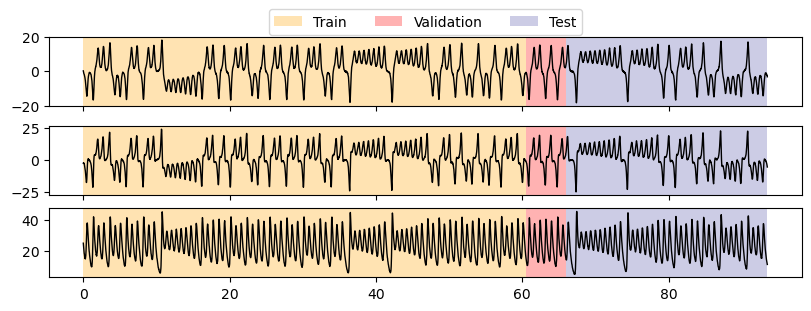

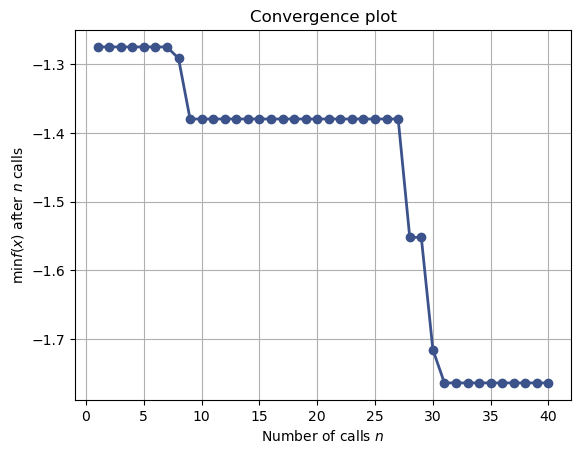

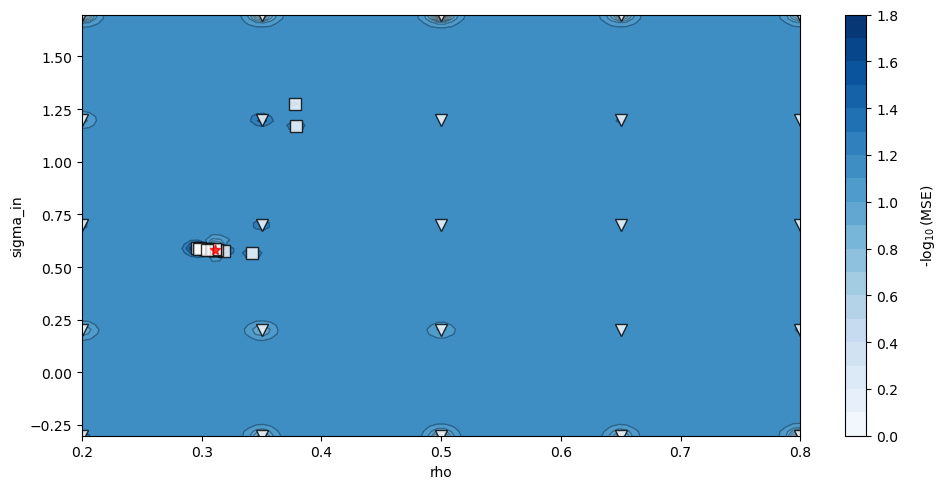

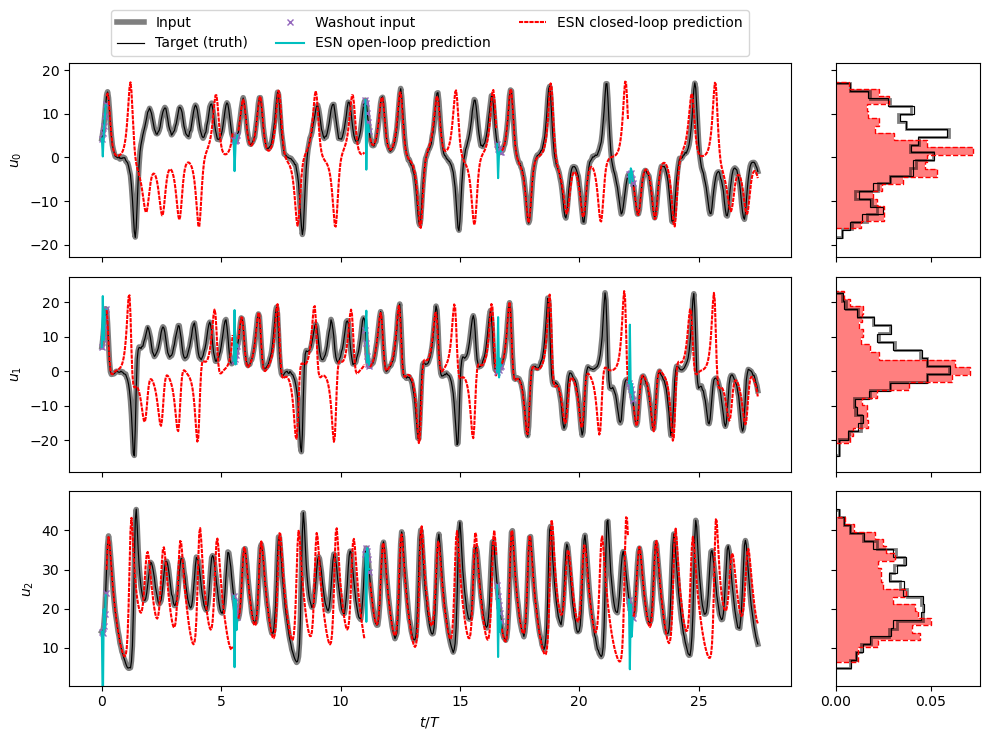

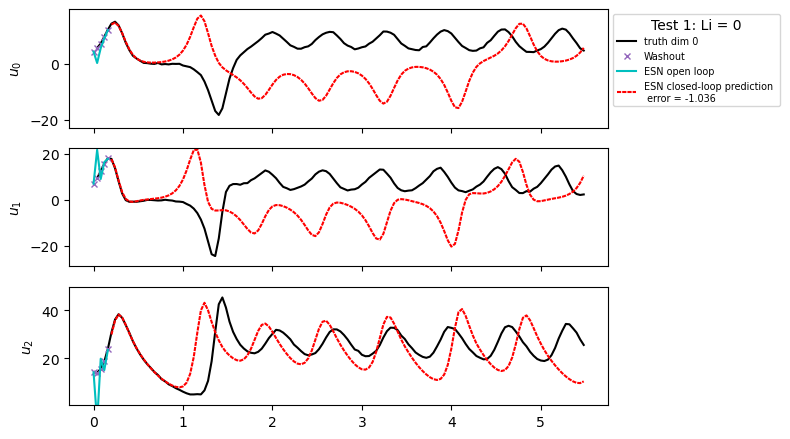

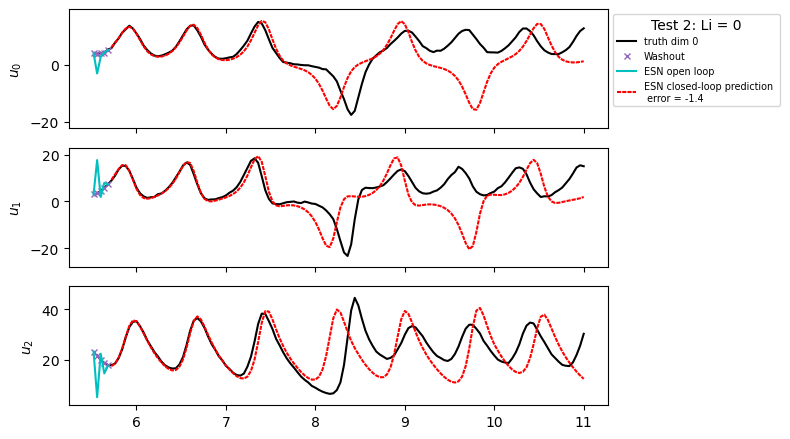

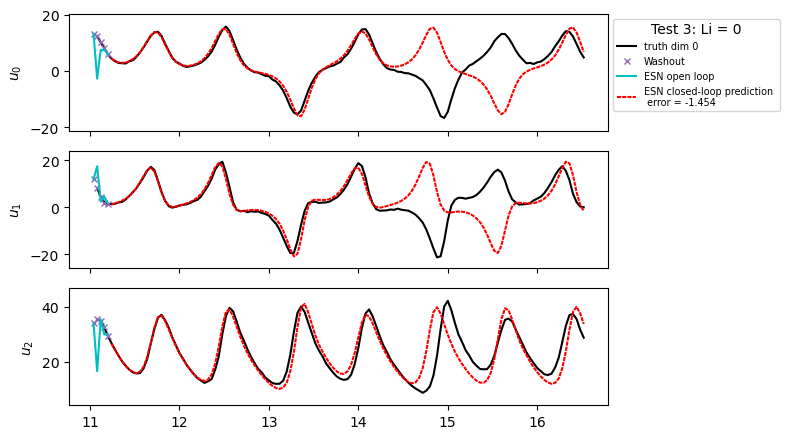

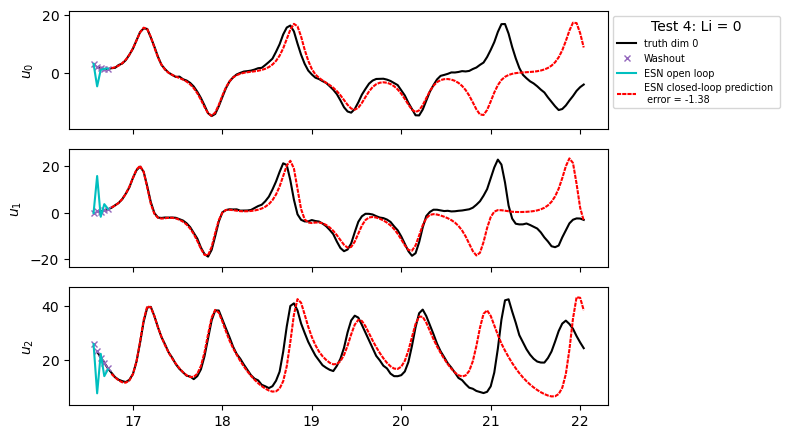

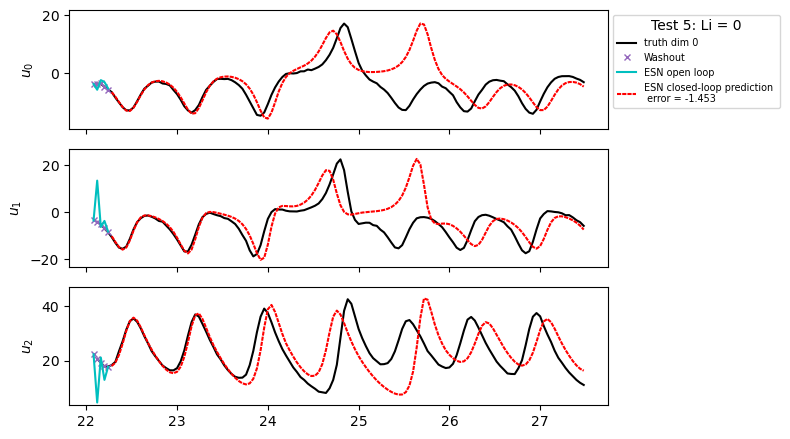

Li = 0: 	 Test min, max and mean MSE in 5 tests = -1.454, -1.036, -1.345.
Overall tests min, max and mean MSE in 5 tests = -1.454, -1.036, -1.345.


In [10]:

training_data = noisy_data[N_transient:sum([N_transient, N_train, N_val, N_test])]


model_datadriven = ESN_model(data=training_data,
                            N_train=N_train,
                            N_val=N_val,
                            N_test=N_test,
                            dt=dt,
                            upsample=2
                            )



## 2. Ensemble forecast

In [27]:
from src.create import create_ensemble

ensemble = create_ensemble(model=model_datadriven,
                           std_psi=0.5, 
                           m=10,
                           est_a=['Wout']
                           )

Model initialized, dt= 0.02, t_CR=5.5, t_transient=0.0


In [32]:
ensemble.N_dim_in

3

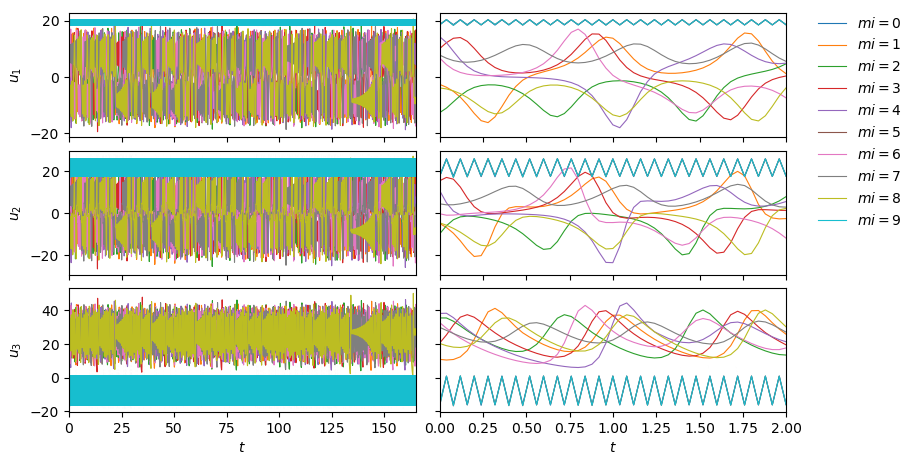

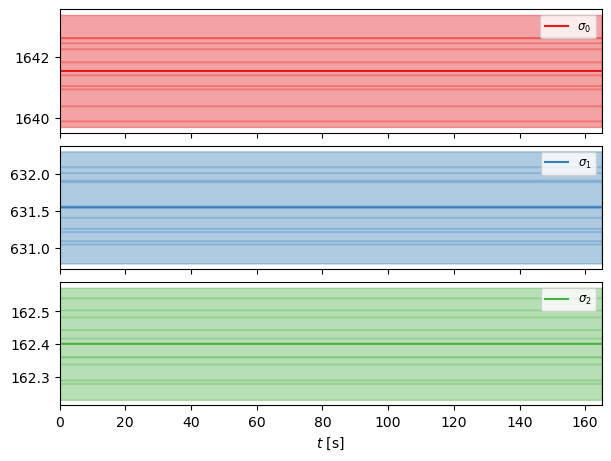

In [30]:
from src.plot_results import plot_obs_timeseries, plot_parameters

psi, t = ensemble.time_integrate(Nt=100*N_lyap)  
ensemble.update_history(psi, t)

# Visualize the time evolution of the physical states
plot_obs_timeseries(ensemble, zoom_window=[0, 2])
if ensemble.Na > 1:
    plot_parameters(ensemble, plot_ensemble_members=True)


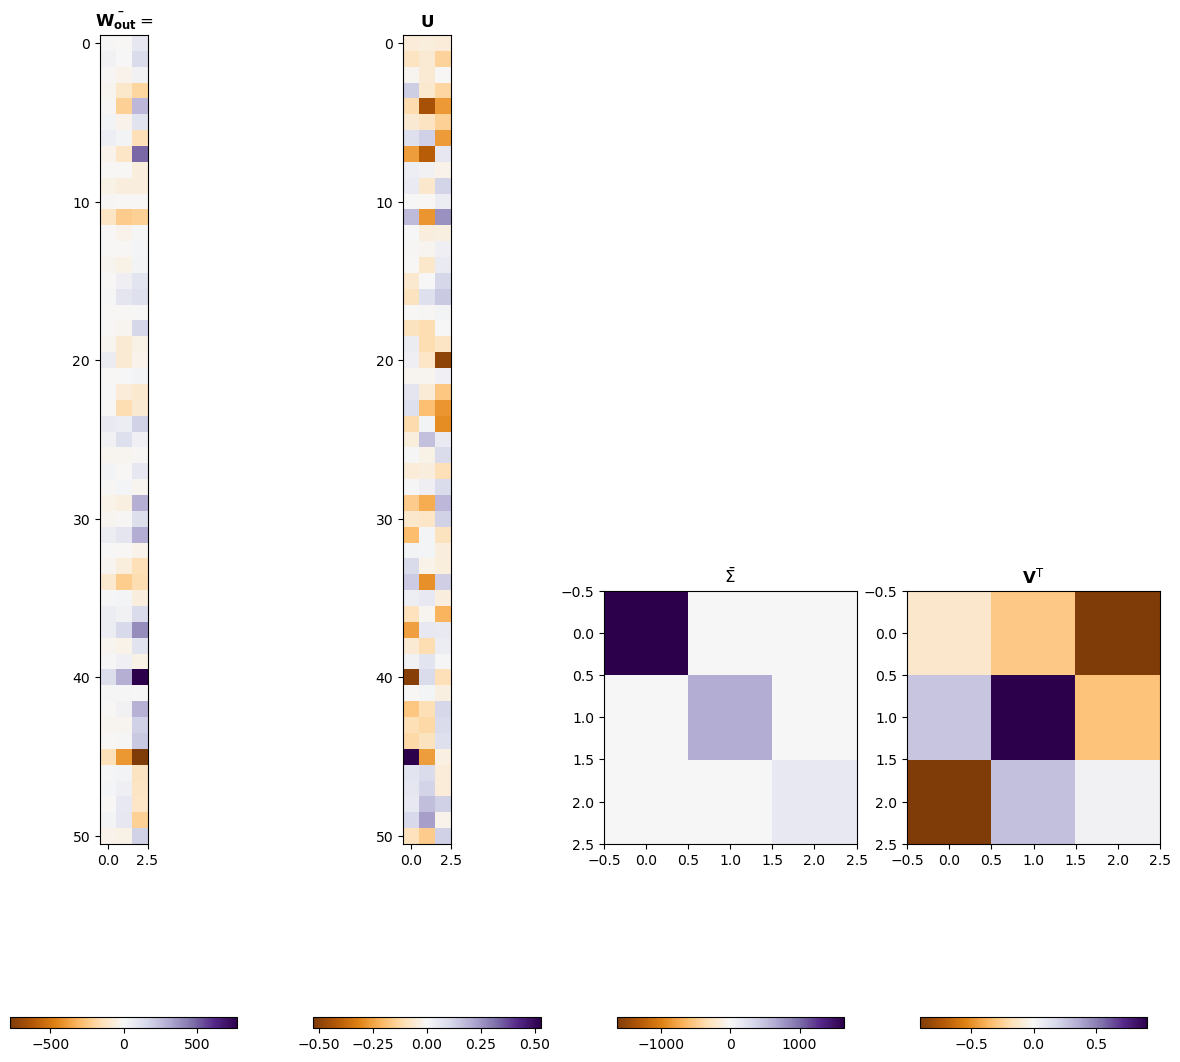

In [31]:
ensemble.plot_Wout()

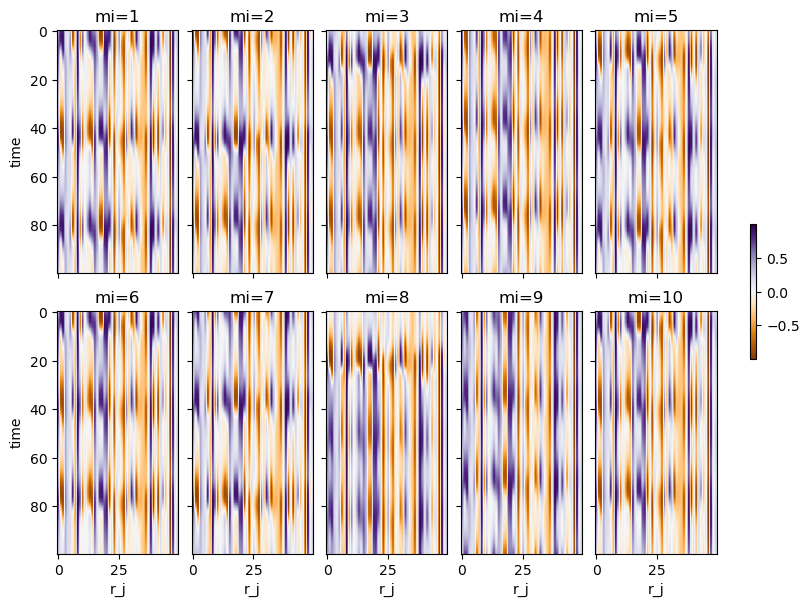

In [21]:
import matplotlib.pyplot as plt

# Visualize the time evolution of the reservoir states



fig = plt.figure(figsize=(8, 6), layout="constrained")
axs = fig.subplots(2, ensemble.m // 2, sharey=True, sharex=True)

r_hist = ensemble.hist[:100, ensemble.Nq:, :]

vmin, vmax = r_hist[:100].min(), r_hist.max()

for mi, ax in enumerate(axs.ravel()):
    im = ax.imshow(r_hist[..., mi], cmap='PuOr', vmin=vmin, vmax=vmax)
    ax.set(title=f'mi={mi+1}')
    if mi in [0, ensemble.m // 2]:
        ax.set(ylabel='time')
    if mi >= ensemble.m // 2:
        ax.set(xlabel='r_j')        
cbar = fig.colorbar(im, ax=axs, orientation='vertical', shrink=0.25)

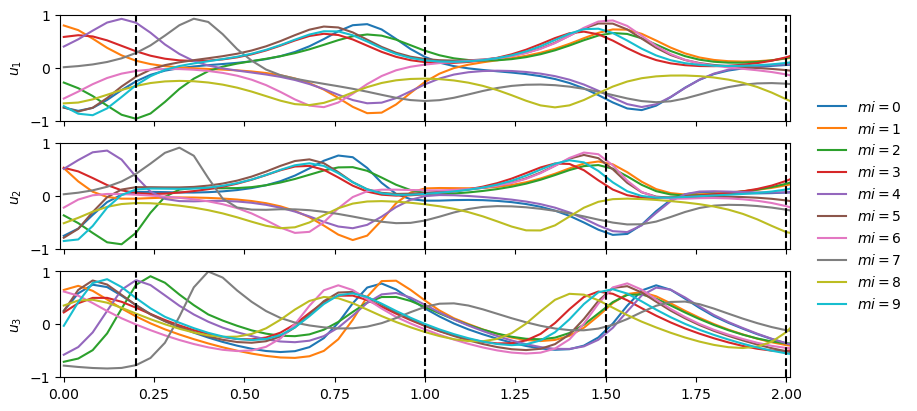

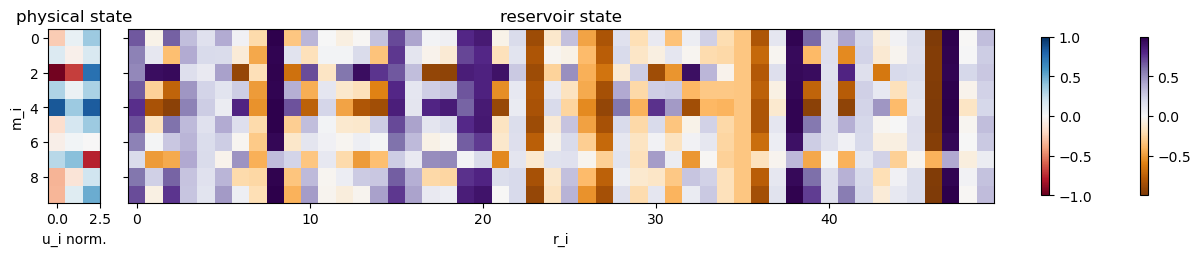

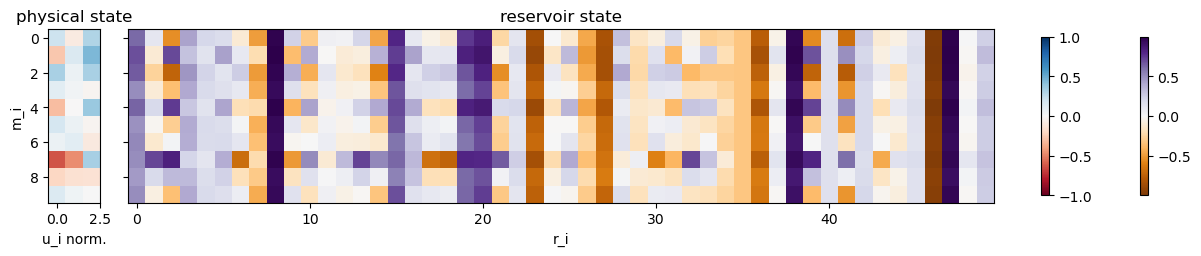

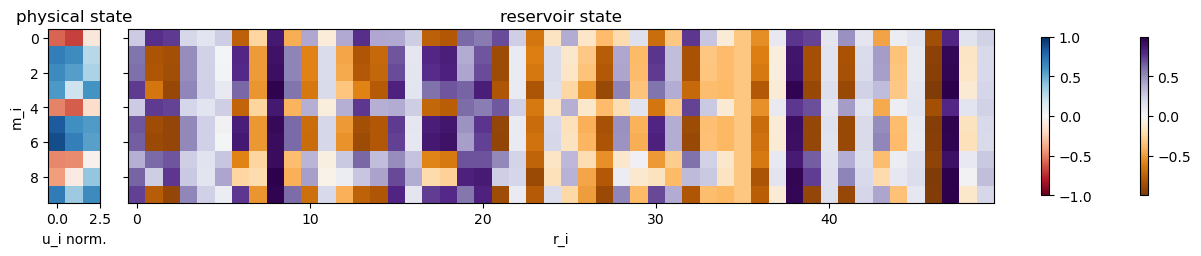

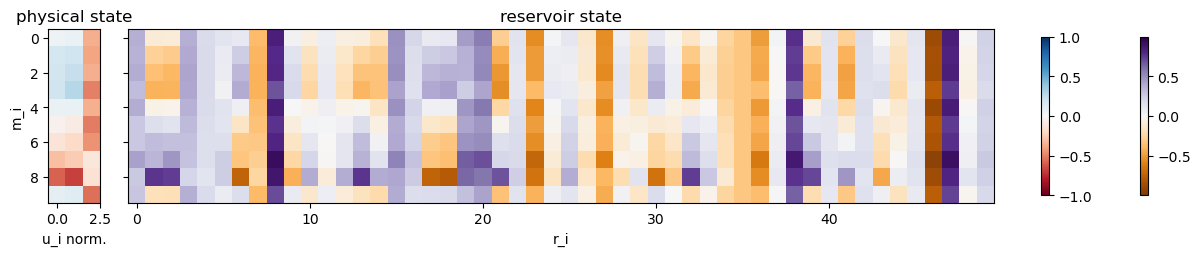

In [22]:
import numpy as np

# Find global min and max for the color scale
vmin, vmax = np.min(ensemble.hist[:, ensemble.Nq:, :]), np.max(ensemble.hist[:, ensemble.Nq:, :])


fig1 = plt.figure(figsize=(8, 4), layout="constrained")
axs1 = fig1.subplots(ensemble.Nq, 1, sharey=True, sharex=True)

y = ensemble.get_observable_hist() # history of the model observables 
lbl = ensemble.obs_labels

norm_u = np.max(np.max(y[100:], axis=0, keepdims=True), axis=-1, keepdims=True).T - np.min(np.min(y[100:], axis=0, keepdims=True), axis=-1, keepdims=True).T
u = (y - np.mean(y, axis=0, keepdims=True)) / (0.5*norm_u)


# Choose a colormap
cmap = plt.get_cmap('tab10', ensemble.m)  

for ii, ax in enumerate(axs1):
    [ax.plot(ensemble.hist_t, u[:, ii, mi], c=cmap(mi)) for mi in range(ensemble.m)]
    ax.set(ylabel=lbl[ii])
   
fig1.legend([f'$mi={mi}$' for mi in range(ensemble.m)], loc='center left', bbox_to_anchor=(1.0, .5), ncol=1, frameon=False)

for ti in [10, 50, 75, 100]:
    for ax in axs1:
        ax.set(xlim=[-.01, ensemble.hist_t[ti]+.01], ylim=[-1, 1])
        ax.axvline(ensemble.hist_t[ti], c='k', ls='--')

    fig = plt.figure(figsize=(12, 8), layout="constrained")
    axs = fig.subplots(1, 2, width_ratios=[ensemble.Nq, ensemble.N_units], sharey=True)
    
    im1 = axs[0].imshow(u[ti].T, cmap='RdBu', vmin=-1, vmax=1)
    axs[0].set(title=f'physical state', ylabel='m_i', xlabel='u_i norm.')
    im2 = axs[1].imshow(ensemble.hist[ti, ensemble.Nq:, :].T, cmap='PuOr', vmin=vmin, vmax=vmax)
    axs[1].set(title=f'reservoir state', xlabel='r_i')
    cbar = fig.colorbar(im2, ax=axs, orientation='vertical', shrink=0.2)
    cbar = fig.colorbar(im1, ax=axs, orientation='vertical', shrink=0.2)


